In [117]:
# Import libraries for this project

# Is there a way we can hide this in the code folder?
%matplotlib inline
import pandas as pd
from pandas import Series
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from datetime import datetime
from pprint import pprint
from time import time
import logging
from sklearn.model_selection import train_test_split

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import preprocessing

#SK-learn libraries for transformation and pre-processing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing

#Seaboarn for EDA
import seaborn as sns
from sklearn.metrics import make_scorer

# Custom classes for this assignment
from kaggle import feature_engineering as fe

# Cusom functions for bikeshare kaggle
from code import bikeshare as bs

# W207 Final Project
## Bike Sharing Demand Kaggle Competition
Team Members: Zach Ingbretsen, Nicholas Chen, Keri Wheatley, and Rob Mulla

Kaggle Website Link: https://www.kaggle.com/c/bike-sharing-demand

## Business Understanding

A public bicycle-sharing system is a service in which bicycles are made available for a shared use to individuals on a very short-term basis. A bike-sharing system is comprised of a network of kiosks throughout a city which allows a participant to check-out a bike at one location and return it to a different location. Participants of a bike-sharing system can rent bikes on an as-needed basis and are charged for the duration of rental. Most programs require participants to register as users prior to usage. As of December 2016, roughly 1000 cities worldwide have bike-sharing systems.

Bike-sharing kiosks act as sensor networks for recording customer demand and usage patterns. For each bike rental, data is recorded for departure location, arrival location, duration of travel, and time elapsed. This data has valuable potential to researchers for studying mobility within a city. For this project, we explore customer mobility in relationship to these factors:
1.     Time of day
2.     Day type (workday, weekend, holiday, etc.)
3.     Season (Spring, Summer, Fall, Winter)
4.     Weather (clear, cloudy, rain, fog, snowfall, etc.)
5.     Temperature (actual, “feels like”)
6.     Humidity
7.     Windspeed

This project explores changes in demand given changes in weather and day. Our project delivers an exploratory data analysis as well as a machine-learning model to forecast bike rental demand. Bike rental demand is measured by total rental count which is further broken down into two rental types: rentals by registered users and rentals by non-registered users.

## Data Understanding

The data sources for this project are provided by Kaggle. Datasets include train data, test data without results, and an example solution submission.

### Data Features

| Feature    | Description                                                                                                                                                                                                                                                                    |
|------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| datetime   | hourly date + timestamp                                                                                                                                                                                                                                                         |
| season     | **1** = spring, **2** = summer, **3** = fall, **4** = winter                                                                                                                                                                                                                                   |
| holiday    | whether the day is considered a holiday                                                                                                                                                                                                                                        |
| workingday | whether the day is neither a weekend nor holiday                                                                                                                                                                                                                               |
| weather    | **1:** Clear, Few clouds, Partly cloudy, Partly cloudy **2:** Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist  **3:** Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds  **4:** A Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog |
| temp       | temperature in Celsius                                                                                                                                                                                                                                                         |
| atemp      | "feels like" temperature in Celsius                                                                                                                                                                                                                                            |
| humidity   | relative humidity                                                                                                                                                                                                                                                              |
| windspeed  | wind speed                                                                                                                                                                                                                                                                     |
| casual     | number of non-registered user rentals initiated                                                                                                                                                                                                                                |
| registered | number of registered user rentals initiated                                                                                                                                                                                                                                    |
| count      | number of total rentals                    

## Exploratory Data Analysis

In [103]:
# Import our data (this uses datetime as index import also below differently)
train_df = pd.read_csv('data/train.csv', index_col=0, infer_datetime_format=True)
train_df.index.name=None # Remove index name to remove confusing datetime column
train_df.index = pd.to_datetime(train_df.index) # Convert index to datetime
test_df = pd.read_csv('data/test.csv', index_col=0, infer_datetime_format=True)
test_df.index.name=None # Remove index name to remove confusing datetime column
test_df.index = pd.to_datetime(test_df.index) # Convert index to datetime

In [104]:
# Describe the numeric features
numeric_features = ['temp','atemp','humidity','windspeed','casual','registered','count']
train_df[numeric_features].describe()

,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


The table above shows the characteristics of numeric variables.

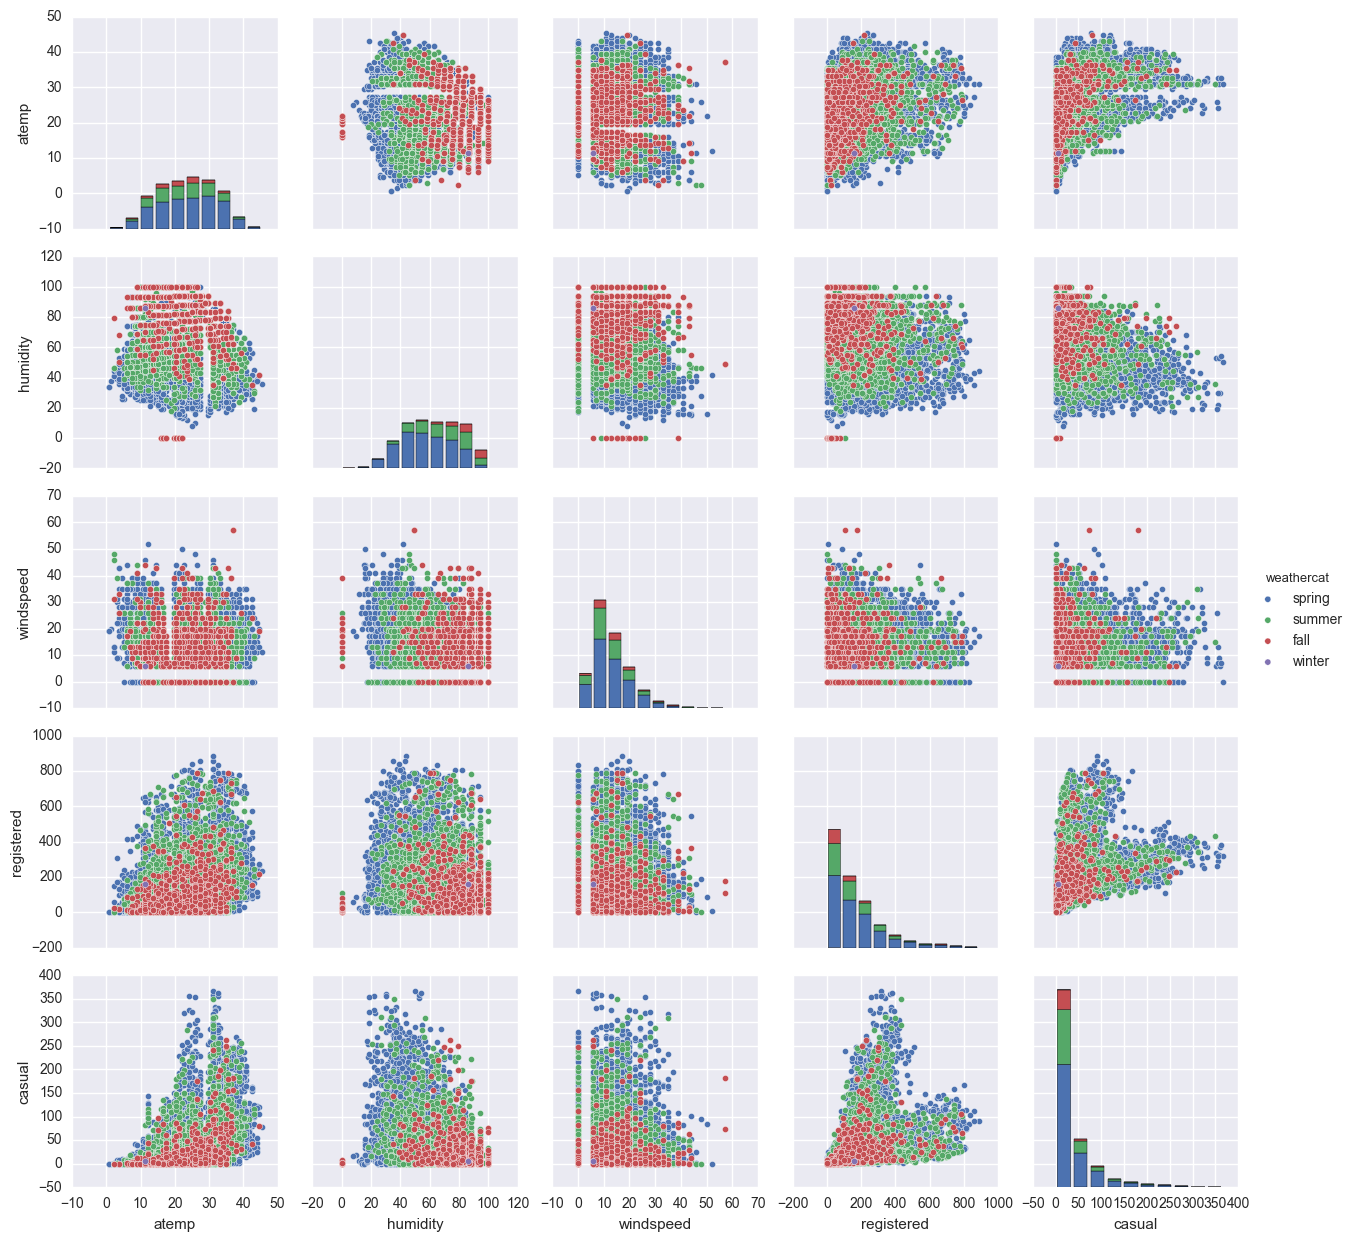

In [105]:
# Create a categorical weather column
train_df['weathercat'] = train_df['weather'].astype('category').\
    cat.rename_categories(['spring','summer','fall','winter'])
    
# Scatterplot all variables
scatplot_train = train_df[['atemp','humidity','windspeed','registered','casual','weathercat']]
sns.pairplot(scatplot_train, hue="weathercat");
train_df.drop('weathercat', 1)
print

The correlation matrix above shows the relationships between the relationships between features and resulting counts. 

1. It appears that atemp affects registered rides linearly while atemp has a more exponential relationship with casual rides.

2. It appears that higher humidities (with humidities greater than 50% being more uncomfortable) affects casual rides more than registered rides.

3. There are many instances of 0 value for wind speed and humidity. Does this point to a data quality issue? 

4. Casual ride data has more variability than registered ride data.

In [106]:
# Do we need this?
# Temp vs Riders Color of rider type
# TODO: MAKE INTO GRID AND ADD ADDITIONAL FEATURES
#fig, axs = plt.subplots(ncols=3)
# sns.jointplot(x="atemp", y="count", color="g", data=train_df, size=3);
# sns.jointplot(x="tempsq", y="count", color="m", data=train_df, size=3);
# sns.jointplot(x="windspeed", y="count", color='b', data=train_df, size=3);

# Do we need this?
# sns.distplot(train_df.atemp, bins=20, kde=False, rug=True);
# sns.lmplot(x='temp', y='count', data=train_df, aspect=1.5, scatter_kws={'alpha':0.2})

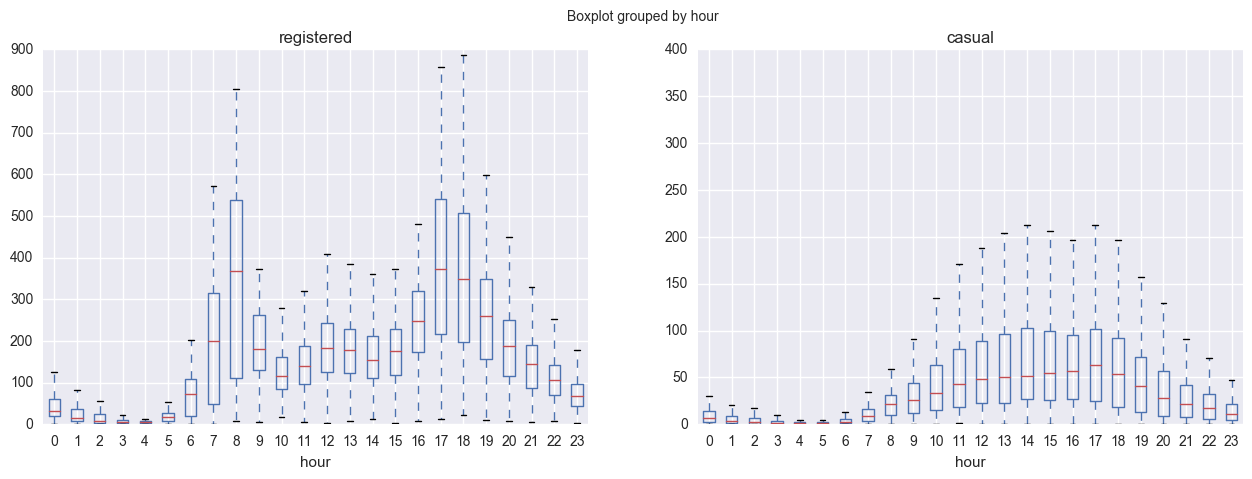

In [176]:
# Transform date variable for EDA
train_df_mod = bs.eda_transform(train_df)

# Create boxplots for registered/casual rides by hour
plt.figure(figsize=(15, 5))
train_df_mod.boxplot(column='registered',by='hour',ax=plt.subplot(1,2,1))
train_df_mod.boxplot(column='casual',by='hour',ax=plt.subplot(1,2,2))
plt.show()

From the boxplots above, it is apparent that 

## Data Preparation

In [10]:
# Import our data again to reset the EDA transforms
# Can we clean up how this is done?
train_df = pd.read_csv('data/train.csv', index_col=0, infer_datetime_format=True)
train_df.index.name=None # Remove index name to remove confusing datetime column
train_df.index = pd.to_datetime(train_df.index) # Convert index to datetime
test_df = pd.read_csv('data/test.csv', index_col=0, infer_datetime_format=True)
test_df.index.name=None # Remove index name to remove confusing datetime column
test_df.index = pd.to_datetime(test_df.index) # Convert index to datetime

In [11]:
# Log our inputs
train_df['casual'] = np.log(train_df['casual']+1)
train_df['registered'] = np.log(train_df['registered']+1)

In [12]:
# Define pipeline
categorical = ('season', 'holiday', 'workingday', )
# datetime isn't numerical, but needs to be in the numeric branch
numerical = ('datetime', 'weather', 'temp', 'atemp', 'humidity', 'windspeed',)
pipeline = Pipeline([
    # process cat & num separately, then join back together
    ('union', FeatureUnion([ 
        ('categorical', Pipeline([
            ('select_cat', fe.SelectCols(cols = categorical)),
            ('onehot', OneHotEncoder()),    
        ])),    
        ('numerical', Pipeline([
            ('select_num', fe.SelectCols(cols = numerical)),
            ('date', fe.DateFormatter()),
            #('drop_datetime', fe.SelectCols(cols = ('datetime'), invert = True)),
            ('temp', fe.ProcessNumerical(cols_to_square = ('temp', 'atemp', 'humidity'))),
            # ('bad_weather', fe.BinarySplitter(col = 'weather', threshold = 2)),
            # ('filter', fe.PassFilter(col='atemp', lb = 15, replacement_style = 'mean'))
            ('scale', StandardScaler()),    
        ])),    
    ])),
    ('to_dense', preprocessing.FunctionTransformer(lambda x: x.todense(), accept_sparse=True)), 
    ('clf', GradientBoostingRegressor(n_estimators=100,random_state=2)),
])

## Modeling

In [13]:
def get_RMSE(actual_values, predicted_values):
    n = len(actual_values)
    RMSE = np.sqrt(np.sum(((np.log(predicted_values + 1) - np.log(actual_values + 1)) ** 2) / n))
    return RMSE

#create custom scorer
RMSE_scorer = make_scorer(get_RMSE, greater_is_better = False)

In [14]:
##############################################
# Split into Dev and Train data and find best parameters
features = [c for c in train_df.columns if c not in ['count', 'casual', 'registered']]
print features

['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed']


In [15]:
# Split the data into train data and a dev data based on day of the month.
# This makes sense since the test data is days 19-30 of the month.
train_data = train_df[train_df.index.day <= 16]
dev_data = train_df[train_df.index.day > 16]

## Evaluation

## Test for casual and registered separately
parameters = {
    'clf__n_estimators': (80,),
    'clf__learning_rate': (0.05,),
    'clf__max_depth': (10,),
    'clf__min_samples_leaf': (20,),
}

print "Casual rides"
bs.train_dev_model_search('casual', parameters, pipeline, RMSE_scorer)

print "Registered rides"
bs.train_dev_model_search('registered', parameters, pipeline, RMSE_scorer)

In [16]:
##############################################
# Create full model using all train data


### CAN WE REMOVE THE COMMENTED OUT PART BELOW?
#casual_best_param = {
#    'clf__n_estimators': (80,),
#    'clf__learning_rate': (0.05,),
#    'clf__max_depth': (10,),
#    'clf__min_samples_leaf': (20,),
#}
#
#registered_best_param = {
#    'clf__n_estimators': (80,),
#    'clf__learning_rate': (0.05,),
#    'clf__max_depth': (10,),
#    'clf__min_samples_leaf': (20,),
#}

full_casual_gs = pipeline.set_params(clf__n_estimators = 80, clf__learning_rate = 0.05, clf__max_depth = 10, clf__min_samples_leaf = 20)
full_casual_gs.fit(train_df[features], train_df['casual'])
full_casual_predicted_y_log = full_casual_gs.predict(test_df[features])
# np.exp converts back from log
full_casual_predicted_y = np.exp(full_casual_predicted_y_log)-1

full_registered_gs = pipeline.set_params(clf__n_estimators = 80, clf__learning_rate = 0.05, clf__max_depth = 10, clf__min_samples_leaf = 20)
full_registered_gs.fit(train_df[features], train_df['registered'])
full_registered_predicted_y_log = full_registered_gs.predict(test_df[features])
# np.exp converts back from log
full_registered_predicted_y = np.exp(full_registered_predicted_y_log)-1

kaggle/feature_engineering.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  X['hour'] = X.index.hour
kaggle/feature_engineering.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  X['weekday'] = X.index.weekday


## Deployment

In [17]:
# index column doesn't have datetime as name... need to fix
test_df['count'] = (np.array([full_casual_predicted_y>0]*full_casual_predicted_y)).T+\
    (np.array([full_registered_predicted_y>0]*full_registered_predicted_y)).T
test_df[['count']].to_csv('data/combined_preds.csv')